In [9]:
import os
import urllib.request
import zipfile
import torch
from torch import nn
from torch.optim import SGD
from torchvision import models, transforms
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from avalanche.benchmarks import dataset_benchmark
from avalanche.training.plugins import LwFPlugin
from avalanche.training import Naive
from avalanche.evaluation.metrics import forgetting_metrics, \
accuracy_metrics, loss_metrics, timing_metrics, cpu_usage_metrics, \
confusion_matrix_metrics, disk_usage_metrics
from avalanche.logging import InteractiveLogger, TensorboardLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin
import matplotlib.pyplot as plt

# 1. Download Tiny ImageNet dataset and extract it
def download_tiny_imagenet(data_dir):
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_file = os.path.join(data_dir, "tiny-imagenet-200.zip")

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    if not os.path.exists(zip_file):
        print("Downloading Tiny ImageNet dataset...")
        urllib.request.urlretrieve(url, zip_file)

    extracted_dir = os.path.join(data_dir, "tiny-imagenet-200")
    if not os.path.exists(extracted_dir):
        print("Extracting dataset...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(data_dir)

    return extracted_dir

data_dir = "../data/data"
tiny_imagenet_dir = '../data/data/tiny-imagenet-200'

# Organize validation set (if needed, we will move the images based on their annotations)
val_dir = os.path.join(tiny_imagenet_dir, 'val')
val_images_dir = os.path.join(val_dir, 'images')
val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')

# Create class subdirectories in the validation folder
def organize_val_images(val_dir, val_images_dir, val_annotations_file):
    if not os.path.exists(val_images_dir):
        return  # Already organized

    print("Organizing validation images into class folders...")
    with open(val_annotations_file, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split('\t')
            img_file, class_id = parts[0], parts[1]
            class_dir = os.path.join(val_dir, class_id)
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)
            
            # Move images into corresponding class folder
            img_src_path = os.path.join(val_images_dir, img_file)
            img_dst_path = os.path.join(class_dir, img_file)
            if os.path.exists(img_src_path):
                os.rename(img_src_path, img_dst_path)

    # Remove the original images folder
    if os.path.exists(val_images_dir):
        os.rmdir(val_images_dir)

organize_val_images(val_dir, val_images_dir, val_annotations_file)

# 2. Define transformations and load Tiny ImageNet data using ImageFolder
transform = transforms.Compose([
    transforms.Resize(64),  # Tiny ImageNet images are 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load train and validation datasets
train_dataset = ImageFolder(root=os.path.join(tiny_imagenet_dir, 'train'), transform=transform)
val_dataset = ImageFolder(root=os.path.join(tiny_imagenet_dir, 'val'), transform=transform)

# 3. 将 train_dataset 分为 50 个 experience
num_experiences = 10
dataset_len = len(train_dataset)
subset_size = dataset_len // num_experiences

# random_split 用于将 train_dataset 划分为 num_experiences 个子集
train_subsets = random_split(train_dataset, [subset_size] * (num_experiences - 1) + [dataset_len - subset_size * (num_experiences - 1)])

# 使用 dataset_benchmark 创建 50 个 experience 的基准
benchmark = dataset_benchmark(
    train_datasets=train_subsets,  # 切分后的 50 个子集
    test_datasets=[val_dataset] * num_experiences  # 每个 experience 使用相同的验证集
)

# 4. Load pre-trained ResNet18 and modify the final layer for 200 classes
resnet18 = models.resnet18(pretrained=True)
# resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Change input channels to 1
num_classes = 200
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# 5. Define optimizer
optimizer = SGD(resnet18.parameters(), lr=0.01)

# 6. Define loss function
criterion = nn.CrossEntropyLoss()

loggers = []

# log to Tensorboard
loggers.append(TensorboardLogger())

# log to text file
loggers.append(TextLogger(open('quantum_lwf_normal_log.txt', 'a')))

# print to stdout
loggers.append(InteractiveLogger())

# 7. Define evaluation plugin for logging metrics
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(experience=True),
    forgetting_metrics(experience=True, stream=True),
    confusion_matrix_metrics(num_classes=num_classes, save_image=True,
                             stream=True),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=loggers
)


In [10]:
###############################################LwF Strategy###############################################
from avalanche.training import LwF

# 1. 定义 LwF 策略，直接使用 LwF 类
strategy = LwF(
    model=resnet18,
    optimizer=optimizer,
    criterion=criterion,
    alpha=0.5,  # 平衡新任务和旧任务损失的权重
    temperature=2.0,  # 蒸馏温度，越高的值越软化
    train_mb_size=32,
    train_epochs=30,
    eval_mb_size=100,
    evaluator=eval_plugin,
    device='cuda:1' if torch.cuda.is_available() else 'cpu'
)

# Save training accuracy and loss history for plotting

# 9. Training and evaluation loop
# Use experiences from Avalanche's benchmark, such as from benchmark.train_stream
results = []    
# Iterate over experiences from the benchmark's training stream
for experience in benchmark.train_stream:
    # Train on the current experience
    strategy.train(experience)
    print('Computing accuracy on the whole test set')
    # Evaluate the current model on the current test experience
    results.append(strategy.eval(benchmark.test_stream))


-- >> Start of training phase << --
100%|██████████| 313/313 [00:29<00:00, 10.61it/s]
Epoch 0 ended.
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 20648.1045
	DiskUsage_MB/train_phase/train_stream/Task000 = 20648.1045
	Loss_Epoch/train_phase/train_stream/Task000 = 4.6165
	Loss_MB/train_phase/train_stream/Task000 = 3.9068
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0022
	Time_Epoch/train_phase/train_stream/Task000 = 29.4663
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1045
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.1875
100%|██████████| 313/313 [00:28<00:00, 10.90it/s]
Epoch 1 ended.
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 20753.4209
	DiskUsage_MB/train_phase/train_stream/Task000 = 20753.4209
	Loss_Epoch/train_phase/train_stream/Task000 = 2.9248
	Loss_MB/train_phase/train_stream/Task000 = 2.4737
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0004
	Time_Epoch/train_phase/train_stream/Task000 = 28.6832
	Top1_Acc_Epoch/train_phase/train

In [ ]:
%load_ext tensorboard

In [13]:
import torch
from avalanche.benchmarks.classic import SplitMNIST
from avalanche.models import SimpleMLP
from avalanche.training import Naive
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics
from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin
import matplotlib.pyplot as plt

# 使用 CUDA 或 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义数据集和基准
benchmark = SplitMNIST(n_experiences=10, seed=1234)

# 定义模型
model = SimpleMLP(num_classes=benchmark.n_classes)

# 优化器和损失函数
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# 数据存储
loss_history = []
accuracy_history = []

# 配置评估器
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(experience=True),
    forgetting_metrics(experience=True, stream=True),
    confusion_matrix_metrics(num_classes=num_classes, save_image=True,
                             stream=True),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=loggers
)

# 定义 Naive 策略
strategy = Naive(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_mb_size=32,
    train_epochs=30,
    eval_mb_size=32,
    device=device,
    evaluator=eval_plugin
)

# 训练和评估
results = []
for experience in benchmark.train_stream:
    print(f"Training on experience {experience.current_experience}")
    strategy.train(experience)  # 训练当前经验
    metrics = strategy.eval(benchmark.test_stream)  # 在测试流上评估

    # 打印 metrics 确认其内容
    results.append(metrics)

Training on experience 0
-- >> Start of training phase << --
349it [00:40,  8.64it/s]
Epoch 0 ended.
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 63098.5547
	DiskUsage_MB/train_phase/train_stream/Task000 = 63098.5547
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0752
	Loss_MB/train_phase/train_stream/Task000 = 0.0019
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0004
	Time_Epoch/train_phase/train_stream/Task000 = 8.5449
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9915
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 170/170 [00:08<00:00, 21.02it/s]
Epoch 1 ended.
	DiskUsage_Epoch/train_phase/train_stream/Task000 = 63154.5547
	DiskUsage_MB/train_phase/train_stream/Task000 = 63154.5547
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0040
	Loss_MB/train_phase/train_stream/Task000 = 0.0036
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0005
	Time_Epoch/train_phase/train_stream/Task000 = 8.0596
	Top1_Acc_Epoch/train_phase/train_s

In [ ]:
%load_ext tensorboard

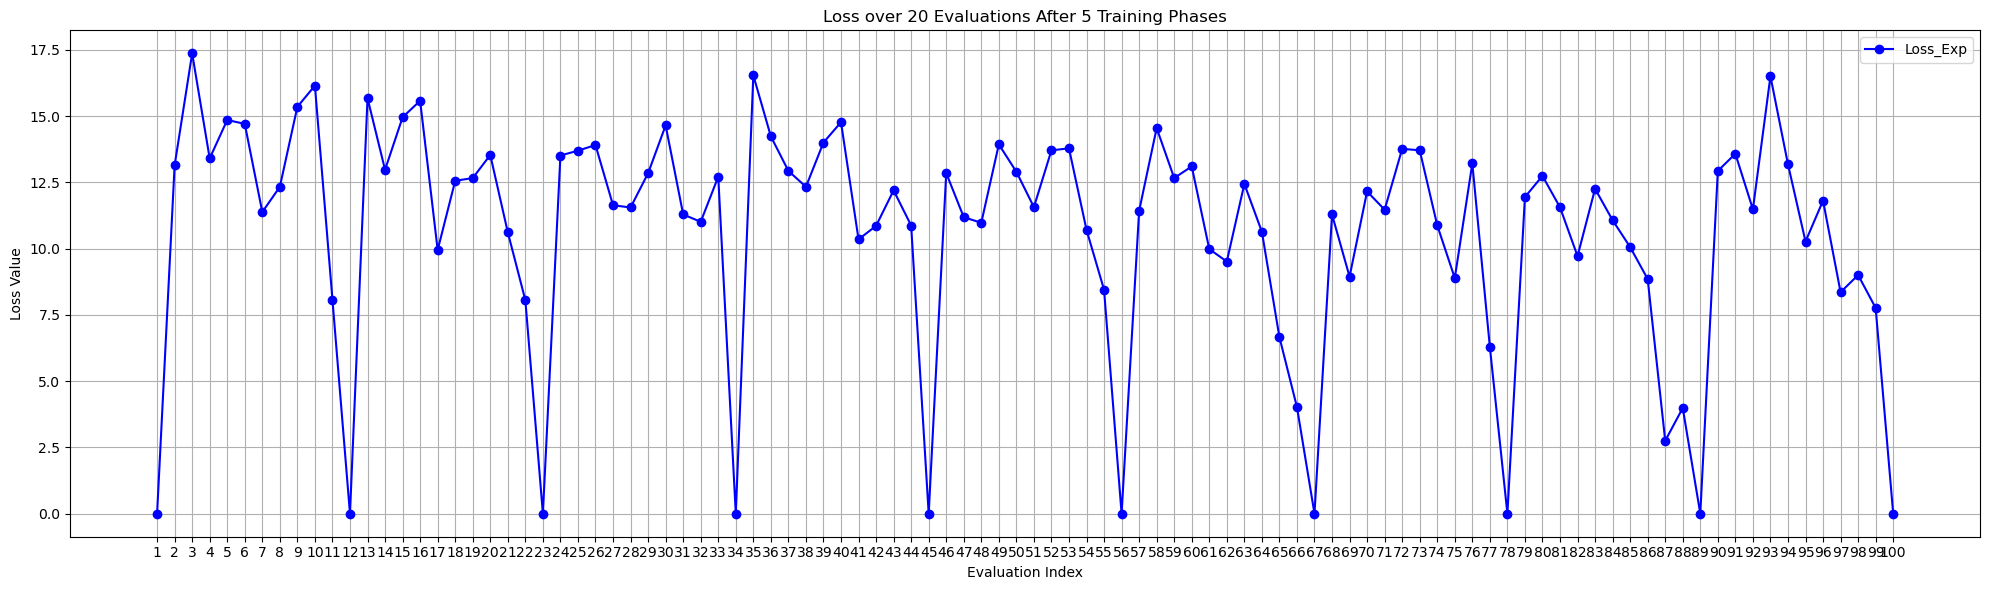

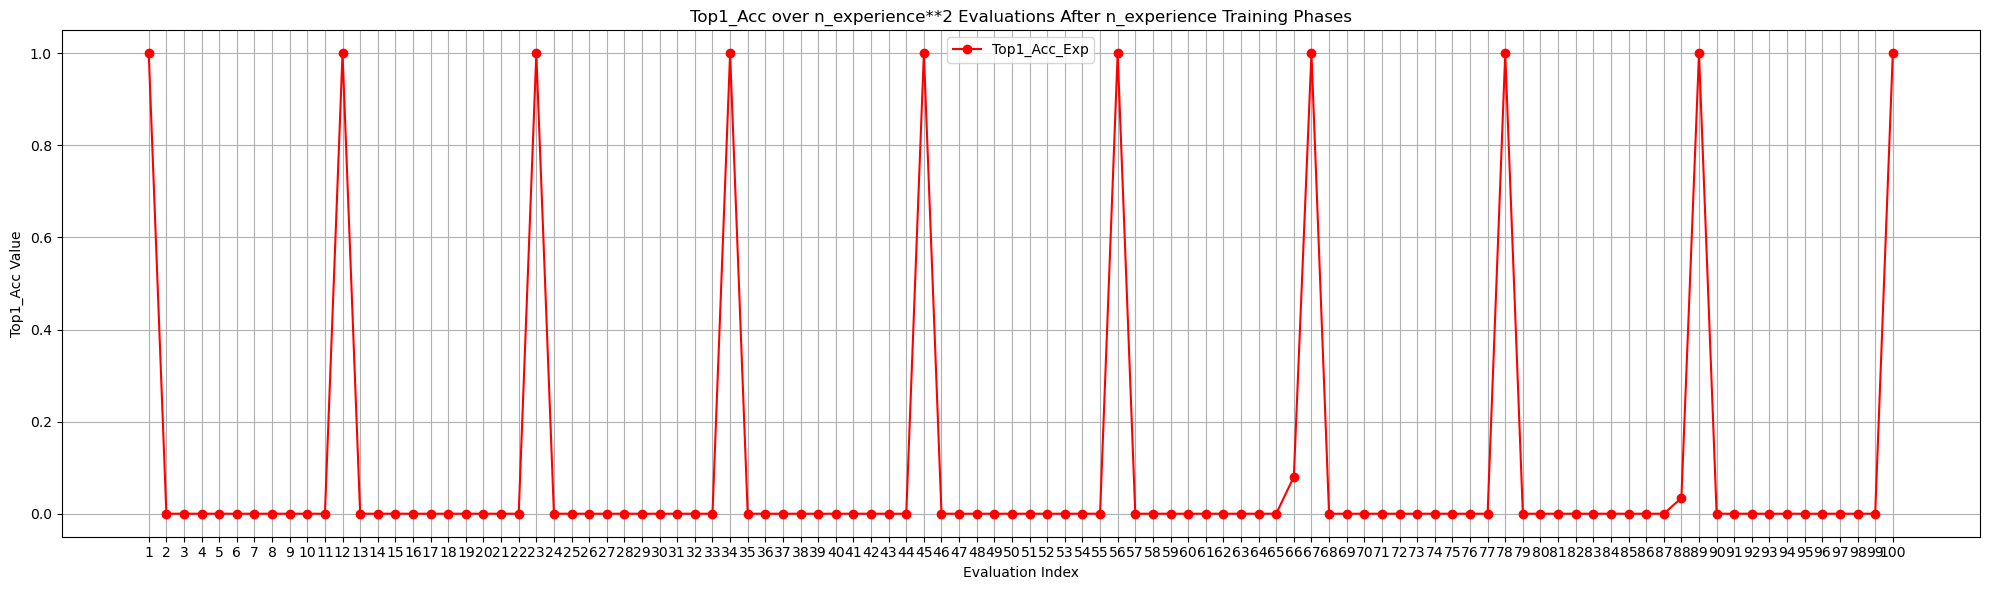

In [14]:
import matplotlib.pyplot as plt
# 初始化列表来存储 Loss 值
loss_values = []
x = []  # x 轴：经验编号（1-20）

# 遍历 results 提取 Loss_Exp 数据
count = 1  # 用于标记经验编号
for train_idx, result in enumerate(results):  # 遍历5次训练的结果
    for exp_id in range(0, num_experiences):  # 每次训练对应4次 eval（Exp001 到 Exp004）
        key = f"Loss_Exp/eval_phase/test_stream/Task000/Exp00{exp_id}"
        loss = result.get(key, None)
        if loss is not None:  # 确保键存在
            loss_values.append(loss)
            x.append(count)  # x 轴连续编号
            count += 1

# 遍历 results 提取 Top1_Acc_Exp 数据
top1_acc_values = []
for train_idx, result in enumerate(results):  # 遍历5次训练的结果
    for exp_id in range(0, num_experiences):  # 每次训练对应4次 eval（Exp001 到 Exp004）
        key = f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00{exp_id}"
        top1_acc = result.get(key, None)
        if top1_acc is not None:  # 确保键存在
            top1_acc_values.append(top1_acc)

# 绘制图形
plt.figure(figsize=(20, 6))
plt.plot(x, loss_values, marker='o', linestyle='-', color='b', label='Loss_Exp')
plt.title("Loss over 20 Evaluations After 5 Training Phases")
plt.xlabel("Evaluation Index")
plt.ylabel("Loss Value")
plt.xticks(range(1, len(x) + 1))  # 设置 x 轴刻度
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(x, top1_acc_values, marker='o', linestyle='-', color='r', label='Top1_Acc_Exp')
plt.title("Top1_Acc over n_experience**2 Evaluations After n_experience Training Phases")
plt.xlabel("Evaluation Index")
plt.ylabel("Top1_Acc Value")
plt.xticks(range(1, len(x) + 1))  # 设置 x 轴刻度
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Training on experience 0
-- >> Start of training phase << --
100%|██████████| 625/625 [00:21<00:00, 29.47it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.8844
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0872
100%|██████████| 625/625 [00:19<00:00, 32.10it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.3529
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1388
100%|██████████| 625/625 [00:20<00:00, 30.37it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.1980
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1639
100%|██████████| 625/625 [00:19<00:00, 32.40it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.1024
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1847
100%|██████████| 625/625 [00:19<00:00, 31.65it/s]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.0095
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2109
-- >> End of training phase << --
-- >> Start of eval 

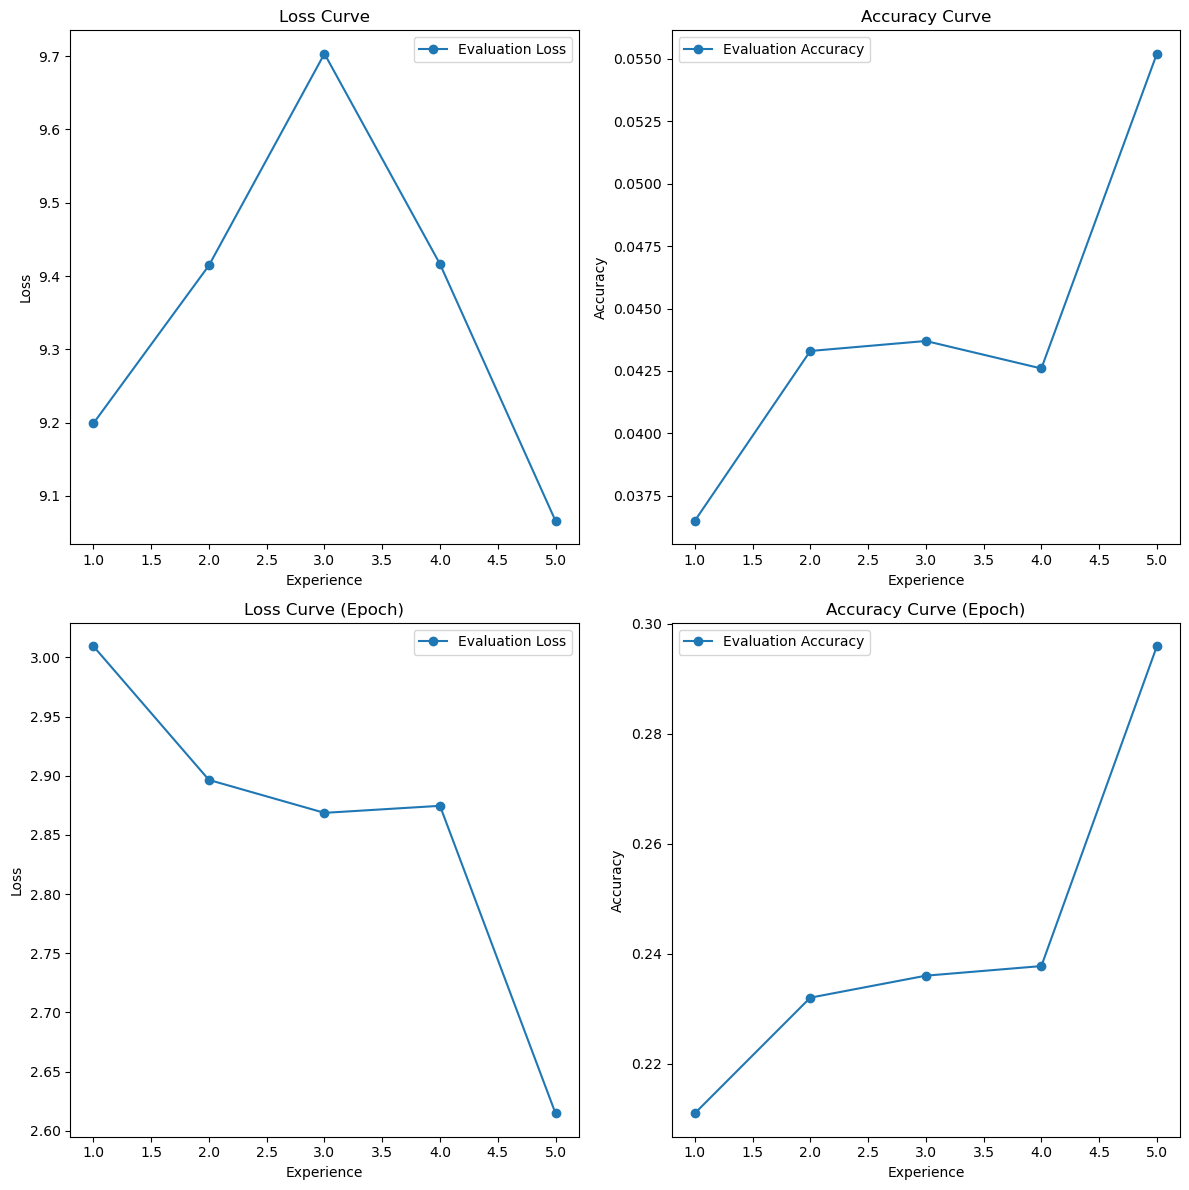

In [ ]:
import torch
from avalanche.benchmarks import nc_benchmark
from avalanche.models import SimpleMLP
from avalanche.training import Naive
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics
from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder

# 使用 CUDA 或 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义数据集路径
data_path = "/home/yangz2/code/data/data/tiny-imagenet-200"  # 替换为你的 Tiny ImageNet 数据集路径

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Tiny ImageNet 的图像尺寸为 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载数据集
train_dataset = ImageFolder(root=f"{data_path}/train", transform=transform)
test_dataset = ImageFolder(root=f"{data_path}/val", transform=transform)

# 定义持续学习基准
benchmark = nc_benchmark(
    train_dataset, test_dataset, n_experiences=15, task_labels=False, seed=1234
)

# 定义模型
model = SimpleMLP(input_size=3 * 64 * 64, num_classes=200)  # Tiny ImageNet 有 200 个类别

# 优化器和损失函数
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# 数据存储
loss_history = []
accuracy_history = []
loss_history_epoch = []
accuracy_history_epoch = []

# 配置评估器
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(experience=True),
    forgetting_metrics(experience=True, stream=True),
    confusion_matrix_metrics(num_classes=num_classes, save_image=True,
                             stream=True),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=loggers
)

# 定义 Naive 策略
strategy = Naive(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_mb_size=32,
    train_epochs=30,
    eval_mb_size=32,
    device=device,
    evaluator=eval_plugin
)

# 训练和评估
for experience in benchmark.train_stream:
    print(f"Training on experience {experience.current_experience}")
    strategy.train(experience)  # 训练当前经验
    metrics = strategy.eval(benchmark.test_stream)  # 在测试流上评估

    # 打印 metrics 确认其内容
    print("Metrics:", metrics)

    # 记录每个 epoch 的损失和准确率
    loss_history_epoch.append(metrics.get('Loss_Epoch/train_phase/train_stream/Task000', 0))
    accuracy_history_epoch.append(metrics.get('Top1_Acc_Epoch/train_phase/train_stream/Task000', 0))

    # 记录损失和准确率
    loss_history.append(metrics.get('Loss_Stream/eval_phase/test_stream/Task000', 0))
    accuracy_history.append(metrics.get('Top1_Acc_Stream/eval_phase/test_stream/Task000', 0))

# 绘制损失曲线和准确率曲线
plt.figure(figsize=(12, 12))

# 损失曲线
plt.subplot(2, 2, 1)
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', label='Evaluation Loss')
plt.title('Loss Curve')
plt.xlabel('Experience')
plt.ylabel('Loss')
plt.legend()

# 准确率曲线
plt.subplot(2, 2, 2)
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, marker='o', label='Evaluation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Experience')
plt.ylabel('Accuracy')
plt.legend()

# 损失曲线（每个 epoch）
plt.subplot(2, 2, 3)
plt.plot(range(1, len(loss_history_epoch) + 1), loss_history_epoch, marker='o', label='Evaluation Loss')
plt.title('Loss Curve (Epoch)')
plt.xlabel('Experience')
plt.ylabel('Loss')
plt.legend()

# 准确率曲线（每个 epoch）
plt.subplot(2, 2, 4)
plt.plot(range(1, len(accuracy_history_epoch) + 1), accuracy_history_epoch, marker='o', label='Evaluation Accuracy')
plt.title('Accuracy Curve (Epoch)')
plt.xlabel('Experience')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.savefig('results/lwf_tiny_imagenet_naive.png')
plt.show()
